In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
import keras
import pandas as pd
import os
%matplotlib inline


Using TensorFlow backend.


In [2]:
def seq_creation(symbol):
    file_name="{}.csv"
    file_name=file_name.format(symbol)
    raw_df=pd.read_csv(os.path.join("data",file_name))
    raw_seq=[tup for tup in raw_df[["price_open","volume_traded","trades_count"]].values]
    raw_seq=np.array(raw_seq)
    return raw_seq

In [3]:
test_seq=seq_creation("BTC1HRS")
print (test_seq)
print(test_seq.shape)

[[  430.89          41.32097223   114.        ]
 [  431.51          31.21223925    70.        ]
 [  430.            12.24623628    42.        ]
 ..., 
 [ 7395.14         247.02564527  1019.        ]
 [ 7422.1          365.39099263  1168.        ]
 [ 7395.68         258.97080512  1131.        ]]
(19776, 3)


In [4]:
import sklearn.preprocessing as skl
def seq_normalization(seq):
    
    scaler=skl.MinMaxScaler((0,1))
    scaler.fit(seq)
    new_seq=scaler.transform(seq)
    
    return new_seq

In [5]:
norm_seq=seq_normalization(test_seq)
print(norm_seq)

[[ 0.0039849   0.00299522  0.00866849]
 [ 0.0040172   0.00225697  0.00523233]
 [ 0.00393852  0.00087188  0.00304569]
 ..., 
 [ 0.36684856  0.01801792  0.07934401]
 [ 0.36825328  0.02666219  0.09098009]
 [ 0.3668767   0.01889028  0.08809059]]


In [6]:
print(norm_seq[17193,:])

[ 0.98708452  0.01469271  0.28020305]


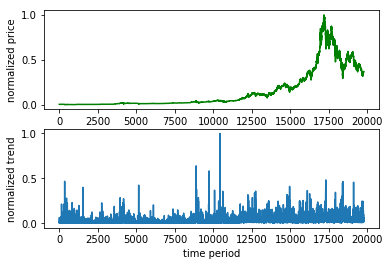

In [7]:
plt.figure(1)
plt.subplot(211)
sp1=plt.plot(norm_seq[:,0])
plt.setp(sp1,color='g')
plt.ylabel('normalized price')

plt.subplot(212)
plt.plot(norm_seq[:,1])
plt.xlabel('time period')
plt.ylabel('normalized trend')
plt.show()

In [8]:
window_size=20

In [9]:
def data_preprocessing(seq, window_size):
    x=[]
    y=[]
    for i in range(len(seq[:,0])-window_size):
        x.append(seq[i:i+window_size,:])
        y.append(seq[i+window_size,0])
    x=np.array(x)
    x=np.reshape(x,(len(seq[:,0])-window_size,window_size,-1))
    y=np.array(y)
    y=np.reshape(y,(-1,1))
    return x,y 
    

In [10]:
x,y=data_preprocessing(norm_seq, window_size)
print(x.shape)
print(y.shape)

(19756, 20, 3)
(19756, 1)


In [11]:
from sklearn.model_selection import train_test_split
split_ratio=0.9
train_X, test_X, train_Y, test_Y=train_test_split(x, y, train_size=split_ratio,shuffle=True)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(17780, 20, 3)
(17780, 1)
(1976, 20, 3)
(1976, 1)


C:\Users\fluo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
def model(input_shape):
    
    X_input=Input(shape=input_shape)
    
    X=LSTM(5)(X_input)
    X=Dense(1)(X)
    
    model=Model(inputs=X_input, outputs=X)
    
    return model

In [13]:
import keras.backend as K
def thresheld_accuracy(y_true,y_pred):
    
    allowed_error=0.01
    y_error=K.abs(y_pred-y_true)/y_true
    print(y_error)
    y_within_error=y_error<=allowed_error
    y_standard=(y_true>float("-inf"))
    print(y_within_error)
    print(y_standard)
    accuracy=K.sum(K.cast(y_within_error,dtype='int8'))/K.sum(K.cast(y_standard,dtype='int8'))
    
    return accuracy

In [14]:
from keras.callbacks import ModelCheckpoint
model=model(input_shape=(window_size,3))
opt=Adam(lr=0.003)
filepath="Checkpoints/weights-improvement-{epoch:03d}-{thresheld_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='thresheld_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.compile(loss='mean_squared_error',optimizer=opt,metrics=[thresheld_accuracy])

Tensor("metrics/thresheld_accuracy/truediv:0", shape=(?, ?), dtype=float32)
Tensor("metrics/thresheld_accuracy/LessEqual:0", shape=(?, ?), dtype=bool)
Tensor("metrics/thresheld_accuracy/Greater:0", shape=(?, ?), dtype=bool)


In [15]:
train_X_1D=train_X[:,:,0]
train_X_1D=np.reshape(train_X_1D,(train_X_1D.shape[0],train_X_1D.shape[1],1))
print(train_X_1D.shape)

(17780, 20, 1)


In [16]:
history=model.fit(train_X, train_Y, epochs=40, batch_size=64,callbacks=callbacks_list,verbose=1)

Epoch 1/40
17780/17780 [==============================] - 5s 263us/step - loss: 0.0020 - thresheld_accuracy: 0.0645
Epoch 2/40
17780/17780 [==============================] - 4s 222us/step - loss: 8.7056e-05 - thresheld_accuracy: 0.1094
Epoch 3/40
17780/17780 [==============================] - 4s 222us/step - loss: 6.4347e-05 - thresheld_accuracy: 0.1262
Epoch 4/40
17780/17780 [==============================] - 4s 224us/step - loss: 5.4315e-05 - thresheld_accuracy: 0.1484
Epoch 5/40
17780/17780 [==============================] - 4s 217us/step - loss: 4.5882e-05 - thresheld_accuracy: 0.1638
Epoch 6/40
17780/17780 [==============================] - 4s 220us/step - loss: 4.3588e-05 - thresheld_accuracy: 0.1652
Epoch 7/40
17780/17780 [==============================] - 4s 221us/step - loss: 3.9248e-05 - thresheld_accuracy: 0.1791
Epoch 8/40
17780/17780 [==============================] - 4s 224us/step - loss: 3.5916e-05 - thresheld_accuracy: 0.1947
Epoch 9/40
17780/17780 [====================

Epoch 27/40
17780/17780 [==============================] - 4s 216us/step - loss: 2.2721e-05 - thresheld_accuracy: 0.2525
Epoch 28/40
17780/17780 [==============================] - 4s 244us/step - loss: 2.3545e-05 - thresheld_accuracy: 0.2422
Epoch 29/40
17780/17780 [==============================] - 4s 222us/step - loss: 2.1761e-05 - thresheld_accuracy: 0.2606
Epoch 30/40
17780/17780 [==============================] - 4s 227us/step - loss: 2.3443e-05 - thresheld_accuracy: 0.2552
Epoch 31/40
17780/17780 [==============================] - 4s 206us/step - loss: 2.2516e-05 - thresheld_accuracy: 0.2462
Epoch 32/40
17780/17780 [==============================] - 4s 207us/step - loss: 2.1301e-05 - thresheld_accuracy: 0.2711
Epoch 33/40
17780/17780 [==============================] - 3s 197us/step - loss: 2.1161e-05 - thresheld_accuracy: 0.2709
Epoch 34/40
17780/17780 [==============================] - 3s 195us/step - loss: 2.2282e-05 - thresheld_accuracy: 0.2585
Epoch 35/40
17780/17780 [=======

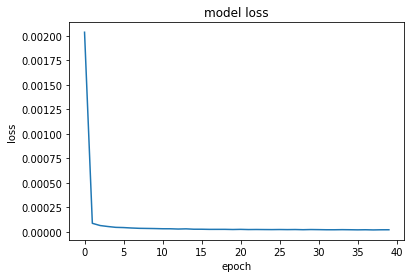

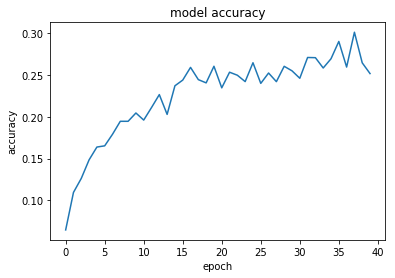

In [17]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['thresheld_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

In [18]:
best_model=load_model("Checkpoints/weights-improvement-038-0.30.hdf5",custom_objects={'thresheld_accuracy':thresheld_accuracy})
print("model loaded")

Tensor("metrics_1/thresheld_accuracy/truediv:0", shape=(?, ?), dtype=float32)
Tensor("metrics_1/thresheld_accuracy/LessEqual:0", shape=(?, ?), dtype=bool)
Tensor("metrics_1/thresheld_accuracy/Greater:0", shape=(?, ?), dtype=bool)
model loaded


In [19]:
print(best_model.metrics_names)

['loss', 'thresheld_accuracy']


In [20]:
score_test = best_model.evaluate(test_X, test_Y,batch_size=64)
print("Test set accuracy = ", score_test[1])

1976/1976 [==============================] - 0s 96us/step
Test set accuracy =  0.203947368602


In [21]:
score_train = best_model.evaluate(train_X, train_Y,batch_size=64)
print("Train set accuracy = ", score_train[1])
print("Train set loss = ", score_train[0])

17780/17780 [==============================] - 1s 46us/step
Train set accuracy =  0.220078740164
Train set loss =  1.9114763294e-05
